## IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

## GPT ARCHITECTURE PART 1: DUMMY GPT MODEL CLASS

<div class="alert alert-block alert-info">

Step 1: Use a placeholder for TransformerBlock

Step 2: Use a placeholder for LayerNorm
</div>

In [5]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<div class="alert alert-block alert-warning">

The DummyGPTModel class in this code defines a simplified version of a GPT-like model using
PyTorch's neural network module (nn.Module). 

The model architecture in the
DummyGPTModel class consists of token and positional embeddings, dropout, a series of
transformer blocks (DummyTransformerBlock), a final layer normalization
(DummyLayerNorm), and a linear output layer (out_head). 

The configuration is passed in via
a Python dictionary, for instance, the GPT_CONFIG_124M dictionary we created earlier.

</div>

<div class="alert alert-block alert-warning">
    
The forward method describes the data flow through the model: it computes token and
positional embeddings for the input indices, applies dropout, processes the data through
the transformer blocks, applies normalization, and finally produces logits with the linear
output layer.

</div>

<div class="alert alert-block alert-warning">

The code above is already functional, as we will see later in this section after we prepare
the input data. 

However, for now, note in the code above that we have used placeholders
(DummyLayerNorm and DummyTransformerBlock) for the transformer block and layer
normalization, which we will develop in later sections

</div>

<div class="alert alert-block alert-success">

Next, we will prepare the input data and initialize a new GPT model to illustrate its
usage.

</div>

### STEP 1: TOKENIZATION

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### STEP 2: CREATE AN INSTANCE OF DUMMYGPTMODEL

In [13]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-warning">

The output tensor has two rows corresponding to the two text samples. Each text sample
consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of
the tokenizer's vocabulary.


The embedding has 50,257 dimensions because each of these dimensions refers to a
unique token in the vocabulary. At the end of this chapter, when we implement the
postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs,
which we can then decode into words.

</div>

<div class="alert alert-block alert-warning">

Now that we have taken a top-down look at the GPT architecture and its in- and outputs,
we will code the individual placeholders in the upcoming sections, starting with the real
layer normalization class that will replace the DummyLayerNorm in the previous code.
</div>

## GPT ARCHITECTURE PART 2: LAYER NORMALIZATION

#### Explanation with a simple example

In [18]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #A
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


<div class="alert alert-block alert-info">

The neural network layer we have coded consists of a Linear layer followed by a non-linear
activation function, ReLU (short for Rectified Linear Unit), which is a standard activation
function in neural networks. 

If you are unfamiliar with ReLU, it simply thresholds negative
inputs to 0, ensuring that a layer outputs only positive values, which explains why the
resulting layer output does not contain any negative values. 

(Note that we will use another,
more sophisticated activation function in GPT, which we will introduce in the next section).
</div>

<div class="alert alert-block alert-success">

Before we apply layer normalization to these outputs, let's examine the mean and
variance:

</div>

In [21]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-warning">

The first row in the mean tensor above contains the mean value for the first input row, and
the second output row contains the mean for the second input row.
</div>

<div class="alert alert-block alert-warning">

Using keepdim=True in operations like mean or variance calculation ensures that the
output tensor retains the same number of dimensions as the input tensor, even though the
operation reduces the tensor along the dimension specified via dim. 

For instance, without
keepdim=True, the returned mean tensor would be a 2-dimensional vector [0.1324,
0.2170] instead of a 2×1-dimensional matrix [[0.1324], [0.2170]].
</div>

<div class="alert alert-block alert-warning">

For a 2D tensor (like a matrix), using dim=-1 for operations such as
mean or variance calculation is the same as using dim=1. 

This is because -1 refers to the
tensor's last dimension, which corresponds to the columns in a 2D tensor. 

Later, when
adding layer normalization to the GPT model, which produces 3D tensors with shape
[batch_size, num_tokens, embedding_size], we can still use dim=-1 for normalization
across the last dimension, avoiding a change from dim=1 to dim=2.

</div>

<div class="alert alert-block alert-success">

Next, let us apply layer normalization to the layer outputs we obtained earlier. The
operation consists of subtracting the mean and dividing by the square root of the variance
(also known as standard deviation):

</div>

In [26]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-info">

Note that the value 2.9802e-08 in the output tensor is the scientific notation for 2.9802 ×
10-8, which is 0.0000000298 in decimal form. This value is very close to 0, but it is not
exactly 0 due to small numerical errors that can accumulate because of the finite precision
with which computers represent numbers.
</div>

<div class="alert alert-block alert-success">

To improve readability, we can also turn off the scientific notation when printing tensor
values by setting sci_mode to False:
</div>

In [29]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-success">

Let's now encapsulate this process in a PyTorch module that we can use in the GPT
model later:
</div>

In [31]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-warning">

This specific implementation of layer Normalization operates on the last dimension of the
input tensor x, which represents the embedding dimension (emb_dim). 

The variable eps is a
small constant (epsilon) added to the variance to prevent division by zero during
normalization. 

The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task. 

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

</div>

_A small note on biased variance_

<div class="alert alert-block alert-info">

In our variance calculation method, we have opted for an implementation detail by
setting unbiased=False. 

For those curious about what this means, in the variance
calculation, we divide by the number of inputs n in the variance formula. 

This approach does not apply Bessel's correction, which typically uses n-1 instead of n in
the denominator to adjust for bias in sample variance estimation. 

This decision results in a so-called biased estimate of the variance. 

For large-scale language
models (LLMs), where the embedding dimension n is significantly large, the
difference between using n and n-1 is practically negligible. 

We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it
reflects TensorFlow's default behavior, which was used to implement the original GPT2 model.
</div>

<div class="alert alert-block alert-success">

Let's now try the LayerNorm module in practice and apply it to the batch input:
</div>

In [36]:
print(batch_example)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


In [37]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-info">

As we can see based on the results, the layer normalization code works as expected and
normalizes the values of each of the two inputs such that they have a mean of 0 and a
variance of 1:
</div>

## GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION

<div class="alert alert-block alert-success">

Let's implement the GELU activation function approximation used by GPT-2:
</div>

In [41]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

<div class="alert alert-block alert-success">

To get an idea of what this GELU function looks like and how it compares to the ReLU
function, let's plot these functions side by side:
</div>

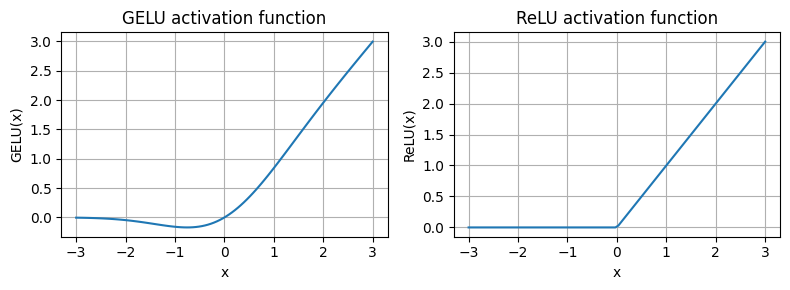

In [43]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">

As we can see in the resulting plot, ReLU is a piecewise linear function that
outputs the input directly if it is positive; otherwise, it outputs zero. 

GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values.
</div>

<div class="alert alert-block alert-warning">

The smoothness of GELU, as shown in the above figure, can lead to better optimization properties
during training, as it allows for more nuanced adjustments to the model's parameters. 

In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder,
especially in networks that are very deep or have complex architectures. 

Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output
for negative values. 

This characteristic means that during the training process, neurons that
receive negative input can still contribute to the learning process, albeit to a lesser extent
than positive inputs.

</div>

<div class="alert alert-block alert-success">

Next, let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later:
</div>

In [47]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [48]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [49]:
print(GPT_CONFIG_124M["emb_dim"])


768


<div class="alert alert-block alert-info">

As we can see in the preceding code, the FeedForward module is a small neural network
consisting of two Linear layers and a GELU activation function. 

In the 124 million parameter GPT model, it receives the input batches with tokens that have an embedding
size of 768 each via the GPT_CONFIG_124M dictionary where GPT_CONFIG_124M["emb_dim"]
= 768.
</div>

<div class="alert alert-block alert-success">

Let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later:
</div>

In [52]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<div class="alert alert-block alert-warning">

The FeedForward module we implemented in this section plays a crucial role in enhancing
the model's ability to learn from and generalize the data. 


Although the input and output dimensions of this module are the same, it internally expands the embedding dimension
into a higher-dimensional space through the first linear layer.

This expansion is followed by a non-linear GELU activation, and then a contraction back to
the original dimension with the second linear transformation. 

Such a design allows for the
exploration of a richer representation space.

</div>

<div class="alert alert-block alert-warning">

Moreover, the uniformity in input and output dimensions simplifies the architecture by
enabling the stacking of multiple layers, as we will do later, without the need to adjust
dimensions between them, thus making the model more scalable.
</div>

## GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS

<div class="alert alert-block alert-success">

Let us see how we can add shortcut connections to the forward method:
</div>

In [57]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


<div class="alert alert-block alert-info">

The code implements a deep neural network with 5 layers, each consisting of a Linear
layer and a GELU activation function. 

In the forward pass, we iteratively pass the input
through the layers and optionally add the shortcut connections  if
the self.use_shortcut attribute is set to True.
</div>

<div class="alert alert-block alert-success">

Let's use this code to first initialize a neural network without shortcut connections. Here,
each layer will be initialized such that it accepts an example with 3 input values and returns
3 output values. The last layer returns a single output value:
</div>

In [60]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

<div class="alert alert-block alert-success">

Next, we implement a function that computes the gradients in the the model's backward
pass:
</div>

In [62]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

<div class="alert alert-block alert-warning">

In the preceding code, we specify a loss function that computes how close the model output
and a user-specified target (here, for simplicity, the value 0) are. 

Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model. 

We can iterate through the weight parameters via model.named_parameters(). 

Suppose we have a 3×3 weight parameter matrix for a given layer. 

In that case, this layer will have 3×3 gradient values, and we print the mean absolute gradient of these 3×3 gradient values to
obtain a single gradient value per layer to compare the gradients between layers more
easily.
</div>

<div class="alert alert-block alert-warning">

In short, the .backward() method is a convenient method in PyTorch that computes loss
gradients, which are required during model training, without implementing the math for the
gradient calculation ourselves, thereby making working with deep neural networks much
more accessible. 
</div>

<div class="alert alert-block alert-success">

Let's now use the print_gradients function and apply it to the model without skip
connections:
</div>

In [66]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


<div class="alert alert-block alert-info">
As we can see based on the output of the print_gradients function, the gradients become
smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which
is a phenomenon called the vanishing gradient problem.
    
</div>

<div class="alert alert-block alert-success">
Let's now instantiate a model with skip connections and see how it compares:
</div>

In [69]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


<div class="alert alert-block alert-info">
As we can see, based on the output, the last layer (layers.4) still has a larger gradient
than the other layers. 

However, the gradient value stabilizes as we progress towards the
first layer (layers.0) and doesn't shrink to a vanishingly small value.
</div>

<div class="alert alert-block alert-warning">

In conclusion, shortcut connections are important for overcoming the limitations posed
by the vanishing gradient problem in deep neural networks. 

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective
training by ensuring consistent gradient flow across layers when we train the GPT model 
</div>

## GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

In [73]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

### THE BUILDING BLOCKS: LAYER NORMALIZATION, GELU AND FEED-FORWARD NEURAL NETWORK

In [75]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

### IMPLEMENTING MULTI-HEAD ATTENTION 

In [77]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-success">
Let us code a transformer block as follows:
</div>

<div class="alert alert-block alert-info">

Step 1: Shortcut connection for attention block

Step 2:  Shortcut connection for feed forward block

Step 3: Add the original input back
</div>

In [80]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

<div class="alert alert-block alert-warning">

The given code defines a TransformerBlock class in PyTorch that includes a multi-head
attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward),
both configured based on a provided configuration dictionary (cfg), such as
GPT_CONFIG_124M
</div>

<div class="alert alert-block alert-warning">

Layer normalization (LayerNorm) is applied before each of these two components, and
dropout is applied after them to regularize the model and prevent overfitting. 

This is also known as Pre-LayerNorm. 

Older architectures, such as the original transformer model,
applied layer normalization after the self-attention and feed-forward networks instead,
known as Post-LayerNorm, which often leads to worse training dynamics.
</div>

<div class="alert alert-block alert-warning">

The class also implements the forward pass, where each component is followed by a
shortcut connection that adds the input of the block to its output. This critical feature helps
gradients flow through the network during training and improves the learning of deep
models 
</div>

<div class="alert alert-block alert-success">
Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer
block and feed it some sample data
</div>

<div class="alert alert-block alert-info">

Create sample input of shape [batch_size, num_tokens, emb_dim]
</div>

In [86]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<div class="alert alert-block alert-info">

As we can see from the code output, the transformer block maintains the input dimensions
in its output, indicating that the transformer architecture processes sequences of data
without altering their shape throughout the network.
</div>

<div class="alert alert-block alert-warning">
    
The preservation of shape throughout the transformer block architecture is not incidental
but a crucial aspect of its design. 

This design enables its effective application across a wide
range of sequence-to-sequence tasks, where each output vector directly corresponds to an
input vector, maintaining a one-to-one relationship. 
</div>

<div class="alert alert-block alert-warning">

However, the output is a context vector
that encapsulates information from the entire input sequence.

This means that while the physical dimensions of the sequence (length and feature size)
remain unchanged as it passes through the transformer block, the content of each output
vector is re-encoded to integrate contextual information from across the entire input
sequence.

</div>

## GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [91]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

<div class="alert alert-block alert-success">
We started with this: A dummy GPT model class
</div>

In [93]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<div class="alert alert-block alert-success">
Then, we coded the Layer Normalization class, Feedforward Neural Network class and also the Transformer class
</div>

<div class="alert alert-block alert-warning">
    
LAYER NORMALIZATION AND FEEDFORWARD NEURAL NETWORK CLASS
</div>

In [96]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

<div class="alert alert-block alert-warning">
    
TRANSFORMER CLASS
</div>

In [98]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

<div class="alert alert-block alert-success">
Now, let us use all this knowledge and code the entire GPT architecture
</div>

In [100]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

<div class="alert alert-block alert-warning">
    
The __init__ constructor of this GPTModel class initializes the token and positional
embedding layers using the configurations passed in via a Python dictionary, cfg. 

These
embedding layers are responsible for converting input token indices into dense vectors and
adding positional information.
</div>

<div class="alert alert-block alert-warning">
    
Next, the __init__ method creates a sequential stack of TransformerBlock modules
equal to the number of layers specified in cfg. 

Following the transformer blocks, a
LayerNorm layer is applied, standardizing the outputs from the transformer blocks to
stabilize the learning process. 

Finally, a linear output head without bias is defined, which
projects the transformer's output into the vocabulary space of the tokenizer to generate
logits for each token in the vocabulary.
</div>

<div class="alert alert-block alert-warning">
    
The forward method takes a batch of input token indices, computes their embeddings,
applies the positional embeddings, passes the sequence through the transformer blocks,
normalizes the final output, and then computes the logits, representing the next token's
unnormalized probabilities. We will convert these logits into tokens and text outputs in the
next section.
</div>

<div class="alert alert-block alert-success">
Let's now initialize the 124 million parameter GPT model using the GPT_CONFIG_124M
dictionary we pass into the cfg parameter and feed it with the batch text input we created
at the beginning of this chapter:
</div>

In [105]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-info">

As we can see, the output tensor has the shape [2, 4, 50257], since we passed in 2 input
texts with 4 tokens each. The last dimension, 50,257, corresponds to the vocabulary size of
the tokenizer. In the next section, we will see how to convert each of these 50,257-
dimensional output vectors back into tokens.
    
</div>

<div class="alert alert-block alert-success">
Using the numel() method, short for "number of elements," we can collect the total
number of parameters in the model's parameter tensors:
</div>

In [108]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


<div class="alert alert-block alert-danger">
Earlier, we spoke of initializing a 124
million parameter GPT model, so why is the actual number of parameters 163 million, as
shown in the preceding code output?
</div>

<div class="alert alert-block alert-warning">
    
The reason is a concept called weight tying that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer. 

To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier:

</div>

In [111]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


<div class="alert alert-block alert-info">

As we can see based on the print outputs, the weight tensors for both these layers have the
same shape:
</div>

<div class="alert alert-block alert-success">
The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying:
</div>

In [114]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


<div class="alert alert-block alert-info">

As we can see, the model is now only 124 million parameters large, matching the original
size of the GPT-2 model.
</div>

<div class="alert alert-block alert-warning">
    
Weight tying reduces the overall memory footprint and computational complexity of the
model. However, in my experience, using separate token embedding and output layers
results in better training and model performance; hence, we are using separate layers in
our GPTModel implementation. The same is true for modern LLMs.

</div>

<div class="alert alert-block alert-success">
Lastly, let us compute the memory requirements of the 163 million parameters in our
GPTModel object:
</div>

In [118]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


<div class="alert alert-block alert-warning">
    
In conclusion, by calculating the memory requirements for the 163 million parameters in
our GPTModel object and assuming each parameter is a 32-bit float taking up 4 bytes, we
find that the total size of the model amounts to 621.83 MB, illustrating the relatively large
storage capacity required to accommodate even relatively small LLMs.

</div>

<div class="alert alert-block alert-warning">
    
In this section, we implemented the GPTModel architecture and saw that it outputs
numeric tensors of shape [batch_size, num_tokens, vocab_size]. In the next section,
we will write the code to convert these output tensors into text.

</div>

## GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS

<div class="alert alert-block alert-success">
Let us implement the token-generation process as follows:
</div>

<div class="alert alert-block alert-info">

Step 1: idx is a (batch, n_tokens) array of indices in the current context

Step 2: Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
context size is 10 then only the last 5 tokens are used as context

Step 3: Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

Step 4: probas has shape (batch, vocab_size)

Step 5: idx_next has shape (batch, 1)

Step 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

</div>

In [124]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

<div class="alert alert-block alert-warning">
    
In the preceeding code, the generate_text_simple function, we use a softmax function to
convert the logits into a probability distribution from which we identify the position with the
highest value via torch.argmax. 

The softmax function is monotonic, meaning it preserves
the order of its inputs when transformed into outputs. 

So, in practice, the softmax step is
redundant since the position with the highest score in the softmax output tensor is the
same position in the logit tensor. 

In other words, we could apply the torch.argmax function
to the logits tensor directly and get identical results. 

However, we coded the conversion to
illustrate the full process of transforming logits to probabilities, which can add additional
intuition, such as that the model generates the most likely next token, which is known as
greedy decoding.

</div>

<div class="alert alert-block alert-warning">
    
In the next chapter, when we will implement the GPT training code, we will also
introduce additional sampling techniques where we modify the softmax outputs such that
the model doesn't always select the most likely token, which introduces variability and
creativity in the generated text.
</div>

<div class="alert alert-block alert-success">
Let's now try out the generate_text_simple function with the "Hello, I am" context
as model input
</div>

<div class="alert alert-block alert-success">
First, we encode the input context into token IDs:
</div>

In [129]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


<div class="alert alert-block alert-success">
Next, we put the model into .eval() mode, which disables random components like
dropout, which are only used during training, and use the generate_text_simple function
on the encoded input tensor:
</div>

<div class="alert alert-block alert-info">

We disable dropout since we are not training the model

</div>

In [132]:
model.eval() #A
#model = GPTModel(GPT_CONFIG_124M)
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


<div class="alert alert-block alert-success">
Using the .decode method of the tokenizer, we can convert the IDs back into text:
</div>

In [134]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


<div class="alert alert-block alert-info">

As we can see, based on the preceding output, the model generated gibberish, which is not
at all coherent text. 

What happened? 

The reason why the model is unable to produce coherent text is that we haven't trained it yet. 

So far, we just
implemented the GPT architecture and initialized a GPT model instance with initial random
weights.

</div>

## EVALUATING GENERATIVE TEXT MODELS

### GPT Model class we coded earlier

In [138]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### Using GPT to generate text

<div class="alert alert-block alert-success">
We initialize a GPT model using the code from the previous chapter
</div>

In [141]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

<div class="alert alert-block alert-warning">
    
We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

This is so that more readers will be able to follow and execute the code examples on their laptop computer
</div>

<div class="alert alert-block alert-success">
    
Next, we use the generate_text_simple function from the previous chapter to generate text.

In addition, we define two convenience functions, text_to_token_ids and token_ids_to_text, for converting between token and text representations that we use throughout this chapter
</div>

In [144]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"



token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


<div class="alert alert-block alert-info">

As we can see above, the model does not produce good text because it has not been trained yet

How do we measure or capture what "good text" is, in a numeric form, to track it during training?

The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress

The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

</div>

### Calculating the text generation loss: cross-entropy and perplexity

<div class="alert alert-block alert-info">

Suppose we have an inputs tensor containing the token IDs for 2 training examples (rows)

Corresponding to the inputs, the targets contain the desired token IDs that we want the model to generate

Notice that the targets are the inputs shifted by 1 position, as explained in chapter 2 when we implemented the data loader

</div>

In [148]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

<div class="alert alert-block alert-success">
    
Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary

Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

</div>

In [150]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


<div class="alert alert-block alert-warning">
    
As discussed in the previous chapter, we can apply the argmax function to convert the probability scores into predicted token IDs.

The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token.

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:                                                                                                                                                                                         
</div>

In [152]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


<div class="alert alert-block alert-success">
    
If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens.

That's because the model wasn't trained yet.

To train the model, we need to know how far it is away from the correct predictions (targets)

</div>

In [154]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


### Cross-entropy loss

<div class="alert alert-block alert-success">

The token probabilities corresponding to the target indices are as follows:


</div>

In [157]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([0.0001, 0.0000, 0.0000])
Text 2: tensor([0.0000, 0.0001, 0.0000])


<div class="alert alert-block alert-warning">

We want to maximize all these values, bringing them close to a probability of 1.
    
In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.

</div>

In [159]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


<div class="alert alert-block alert-success">

Next, we compute the average log probability:
</div>

In [161]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


<div class="alert alert-block alert-info">

The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.

The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

</div>

In [163]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


<div class="alert alert-block alert-success">

PyTorch already implements a cross_entropy function that carries out the previous steps

Before we apply the cross_entropy function, let's check the shape of the logits and targets

</div>

In [165]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


<div class="alert alert-block alert-success">

For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:


</div>

In [167]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


<div class="alert alert-block alert-info">

Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.
    
The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

</div>

In [169]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### Perplexity

<div class="alert alert-block alert-success">

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

</div>

In [172]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


<div class="alert alert-block alert-info">

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution
    
</div>

### Calculating the training and validation set losses

<div class="alert alert-block alert-success">

We use a relatively small dataset for training the LLM (in fact, only one short story)

The reasons are:

You can run the code examples in a few minutes on a laptop computer without a suitable GPU.

The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes.
    
We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size.
    
For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately 30 dollars. 

So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * 30 = 690,000 dollars

Below, we use the same dataset we used in chapter 2.

</div>

In [176]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

<div class="alert alert-block alert-success">

A quick check that the text loaded ok by printing the first and last 100 words

</div>

In [178]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [179]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [180]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [181]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


<div class="alert alert-block alert-warning">

With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later).

Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training.
    
Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position    
</div>

### Implementing the DataLoader:


In [184]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [185]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [186]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [187]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

<div class="alert alert-block alert-info">

We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with.

Llama 2 7B was trained with a batch size of 1024, for example.
    
</div>

<div class="alert alert-block alert-success">

An optional check that the data was loaded correctly:

</div>

In [190]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


<div class="alert alert-block alert-success">

An optional check that the data was loaded correctly:

</div>

In [192]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


### Here is the GPT Model class we coded earlier. We will need this

In [194]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

<div class="alert alert-block alert-success">

Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader.
</div>

In [196]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

<div class="alert alert-block alert-info">

If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
    
Via the device setting, we ensure that the data is loaded onto the same device as the LLM model.
    
</div>

In [198]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


## TRAINING LOOP FOR THE LLM

In [200]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

<div class="alert alert-block alert-info">

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch
    
</div>

In [202]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

<div class="alert alert-block alert-info">

The evaluate_model function calculates the loss over the training and
validation set while ensuring the model is in evaluation mode with gradient tracking and
dropout disabled when calculating the loss over the training and validation sets
    
</div>

In [204]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

<div class="alert alert-block alert-info">

The generate_and_print_sample function is a convenience function that we use to track whether the model improves during the training. 

In particular, the generate_and_print_sample function takes a text snippet (start_context) as input,
converts it into token IDs, and feeds it to the LLM to generate a text sample using the
generate_text_simple function we used earlier
    
</div>

<div class="alert alert-block alert-success">

Let's see this all in action by training a GPTModel instance for 10 epochs using an AdamW
optimizer and the train_model_simple function we defined earlier.
</div>

In [207]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

<div class="alert alert-block alert-info">

As we can see, based on the results printed during the training, the training loss improves
drastically, starting with a value of 9.781 and converging to 0.391. 

The language skills of
the model have improved quite a lot. In the beginning, the model is only able to append
commas to the start context ("Every effort moves you,,,,,,,,,,,,") or repeat the
word "and". 

At the end of the training, it can generate grammatically correct text.
    
</div>

<div class="alert alert-block alert-info">

Similar to the training set loss, we can see that the validation loss starts high (9.856)
and decreases during the training. 

However, it never becomes as small as the training set
loss and remains at 6.372 after the 10th epoch.
    
</div>

<div class="alert alert-block alert-success">

Let's create a simple plot that shows the training and validation set losses side by side
</div>

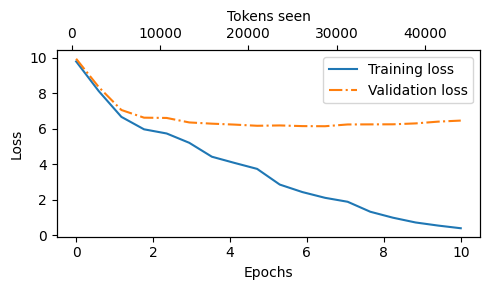

In [211]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

<div class="alert alert-block alert-warning">

Both the training and validation losses start to improve for the first
epoch. However, the losses start to diverge past the second epoch. 

This divergence and the
fact that the validation loss is much larger than the training loss indicate that the model is
overfitting to the training data. 

We can confirm that the model memorizes the training data
verbatim by searching for the generated text snippets, such as "quite insensible to the
irony" in the "The Verdict" text file.


This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs. 

Usually, it's common to train a model
on a much, much larger dataset for only one epoch.   
</div>

## DECODING STRATEGIES TO CONTROL RANDOMNESS

<div class="alert alert-block alert-success">

First, we briefly revisit the generate_text_simple function
from the previous chapter that we used inside the generate_and_print_sample earlier in
this chapter. 

Then, we will cover two techniques, temperature scaling, and top-k sampling,
to improve this function.
</div>

<div class="alert alert-block alert-success">

We begin by transferring the model back from the GPU to the CPU since inference with a
relatively small model does not require a GPU. Also, after training, we put the model into
evaluation model to turn off random components such as dropout:
</div>

In [216]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

<div class="alert alert-block alert-success">

Next, we plug the GPTModel instance (model) into the generate_text_simple function,
which uses the LLM to generate one token at a time:
</div>

In [218]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


### DECODING STRATEGY 1: TEMPERATURE SCALING

<div class="alert alert-block alert-success">

Previously, inside the generate_text_simple function, we always sampled the token
with the highest probability as the next token using torch.argmax, also known as greedy
decoding. 

To generate text with more variety, we can replace the argmax with a function
that samples from a probability distribution (here, the probability scores the LLM generates
for each vocabulary entry at each token generation step).

</div>

<div class="alert alert-block alert-success">

To illustrate the probabilistic sampling with a concrete example, let's briefly discuss the
next-token generation process using a very small vocabulary for illustration purposes:

</div>

In [222]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

<div class="alert alert-block alert-success">

Next, assume the LLM is given the start context "every effort moves you" and
generates the following next-token logits:

</div>

In [224]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

next_token_logits2 = next_token_logits/0.1

next_token_logits3 = next_token_logits/5

<div class="alert alert-block alert-success">

As discussed in the previous chapter, inside the generate_text_simple, we convert the
logits into probabilities via the softmax function and obtain the token ID corresponding the
generated token via the argmax function, which we can then map back into text via the
inverse vocabulary:

</div>

In [226]:
probas = torch.softmax(next_token_logits2, dim=0)

print(probas)



tensor([0.0000, 0.0000, 0.0000, 0.9910, 0.0000, 0.0000, 0.0000, 0.0090, 0.0000])


In [227]:
probas = torch.softmax(next_token_logits3, dim=0)

print(probas)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [228]:
probas = torch.softmax(next_token_logits, dim=0)

print(probas)

next_token_id = torch.argmax(probas).item()

print(next_token_id)

print(inverse_vocab[next_token_id])

tensor([0.0609, 0.0016, 0.0001, 0.5721, 0.0034, 0.0001, 0.0001, 0.3576, 0.0040])
3
forward


<div class="alert alert-block alert-success">

To implement a probabilistic sampling process, we can now replace the argmax with the
multinomial function in PyTorch:

</div>

In [230]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


<div class="alert alert-block alert-success">

The printed output is "forward" just like before. What happened? The multinomial
function samples the next token proportional to its probability score. 

In other words,
"forward" is still the most likely token and will be selected by multinomial most of the
time but not all the time. 

To illustrate this, let's implement a function that repeats this
sampling 1000 times:

</div>

In [232]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


<div class="alert alert-block alert-info">

As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time. 

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".
    
</div>

<div class="alert alert-block alert-success">

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0:

</div>

<div class="alert alert-block alert-success">

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values:

</div>

In [236]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

##Multinomial

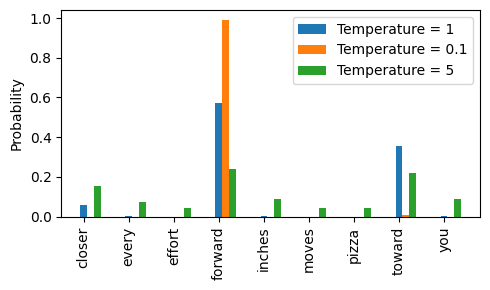

In [237]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

<div class="alert alert-block alert-info">

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores. 

In other words, using a temperature of 1 is the same as not
using any temperature scaling. 

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    
</div>

<div class="alert alert-block alert-info">

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function. 

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often. 

This can add more variety to the
generated texts but also more often results in nonsensical text. 

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.
    
</div>

### DECODING STRATEGY 2: Top-k sampling

<div class="alert alert-block alert-success">

In the previous section, we implemented a probabilistic sampling approach coupled with
temperature scaling to increase the diversity of the outputs. 

We saw that higher
temperature values result in more uniformly distributed next-token probabilities, which
result in more diverse outputs as it reduces the likelihood of the model repeatedly selecting
the most probable token. 

This method allows for exploring less likely but potentially more
interesting and creative paths in the generation process. 

However, One downside of this
approach is that it sometimes leads to grammatically incorrect or completely nonsensical
outputs such as "every effort moves you pizza".
</div>

<div class="alert alert-block alert-success">

In this section, we introduce another concept called top-k sampling, which, when
combined with probabilistic sampling and temperature scaling, can improve the text
generation results.

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores.
    
</div>

In [243]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [244]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


<div class="alert alert-block alert-success">

Subsequently, we apply PyTorch's where function to set the logit values of tokens that are
below the lowest logit value within our top-3 selection to negative infinity (-inf).
    
</div>

In [246]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


<div class="alert alert-block alert-success">

Lastly, let's apply the softmax function to turn these into next-token probabilities:
    
</div>

In [248]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Merge Temperature Scaling and Top-k sampling

<div class="alert alert-block alert-success">

We can now apply the temperature scaling and multinomial function for probabilistic
sampling introduced in the previous section to select the next token among these 3 nonzero probability scores to generate the next token. We do this in the next section by
modifying the text generation function.

</div>

<div class="alert alert-block alert-success">

The previous two subsections introduced two concepts to increase the diversity of LLMgenerated text: temperature sampling and top-k sampling. In this section, we combine and
add these concepts to modify the generate_simple function we used to generate text via
the LLM earlier, creating a new generate function:

</div>

<div class="alert alert-block alert-info">

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling
    
Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified

</div>

In [253]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

<div class="alert alert-block alert-success">

Let's now see this new generate function in action:
</div>

In [255]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


<div class="alert alert-block alert-success">

As we can see, the generated text is very different from the one we previously generated
via the generate_simple function earlier ("Every effort moves
you know," was one of the axioms he laid...!"), which was a memorized passage
from the training set.

</div>

## LOADING AND SAVING MODEL WEIGHTS IN PYTORCH

<div class="alert alert-block alert-success">

Fortunately, saving a PyTorch model is relatively straightforward. 

The recommended way is to save a model's so-called state_dict, a dictionary mapping each layer to its parameters,
using the torch.save function as follows:
</div>

In [259]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

<div class="alert alert-block alert-info">

In the preceding code, "model.pth" is the filename where the state_dict is saved. 

The .pth extension is a convention for PyTorch files, though we could technically use any file
extension.

</div>

<div class="alert alert-block alert-success">

Then, after saving the model weights via the state_dict, we can load the model
weights into a new GPTModel model instance as follows:
</div>

In [262]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

<div class="alert alert-block alert-success">

If we plan to continue pretraining a model later, for example, using the
train_model_simple function we defined earlier in this chapter, saving the optimizer state
is also recommended.
</div>

<div class="alert alert-block alert-success">

Adaptive optimizers such as AdamW store additional parameters for each model weight.
AdamW uses historical data to adjust learning rates for each model parameter dynamically.
                                                   
Without it, the optimizer resets, and the model may learn suboptimally or even fail to
converge properly, which means that it will lose the ability to generate coherent text. 

Using
torch.save, we can save both the model and optimizer state_dict contents as follows:
</div>

In [265]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

<div class="alert alert-block alert-success">
Then, we can restore the model and optimizer states as follows by first loading the saved
data via torch.load and then using the load_state_dict method:
</div>

In [267]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## LOADING PRETRAINED WEIGHTS FROM OPENAI

<div class="alert alert-block alert-success">
    
Previously, for educational purposes, we trained a small GPT-2 model using a limited
dataset comprising a short-story book.

This approach allowed us to focus on the
fundamentals without the need for extensive time and computational resources.

    
Fortunately, OpenAI openly shared the weights of their GPT-2 models, thus eliminating
the need to invest tens to hundreds of thousands of dollars in retraining the model on a
large corpus ourselves.
</div>

<div class="alert alert-block alert-success">
    
In the remainder of this section, we load these weights into our GPTModel class and use
the model for text generation. 

Here, weights refer to the weight parameters that are stored
in the .weight attributes of PyTorch's Linear and Embedding layers, for example. 

We accessed them earlier via model.parameters() when training the model.
</div>

<div class="alert alert-block alert-success">
    
Note that OpenAI originally saved the GPT-2 weights via TensorFlow, which we have to
install to load the weights in Python. 

Moreover, the following code will use a progress bar
tool called tqdm to track the download process, which we also have to install.
</div>

In [272]:
pip install tensorflow>=2.15.0 tqdm>=4.66

zsh:1: 2.15.0 not found
Note: you may need to restart the kernel to use updated packages.


In [273]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.16.1
tqdm version: 4.66.4


<div class="alert alert-block alert-success">
    
We download the gpt_download.py Python module directly from this chapter's online repository
</div>

<div class="alert alert-block alert-success">
    
We can now import the download_and_load_gpt2 function from the gpt_download.py
file as follows, which will load the GPT-2 architecture settings (settings) and weight
parameters (params) into our Python session:
</div>

In [276]:
from gpt_download3 import download_and_load_gpt2

In [277]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


<div class="alert alert-block alert-success">
    
After the execution of the previous code has been completed, let's inspect the contents of
settings and params:
</div>

In [279]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


<div class="alert alert-block alert-success">
    
Both settings and params are Python dictionaries. The settings dictionary stores the LLM
architecture settings similarly to our manually defined GPT_CONFIG_124M settings. 

The
params dictionary contains the actual weight tensors. 

    
Note that we only printed the
dictionary keys because printing the weight contents would take up too much screen space
</div>

<div class="alert alert-block alert-success">
    
We can inspect these weight tensors by printing the whole dictionary via
print(params) or by selecting individual tensors via the respective dictionary keys, for
example, the embedding layer weights:

</div>

In [282]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


<div class="alert alert-block alert-success">
    
We downloaded and loaded the weights of the smallest GPT-2 model via the
download_and_load_gpt2(model_size="124M", ...) setting. However, note that OpenAI
also shares the weights of larger models: "355M", "774M", and "1558M".

</div>

<div class="alert alert-block alert-success">
    
Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our GPTModel instance.

First, we initialize a new GPTModel instance.

Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting qkv_bias to True in our implementation, too.
                                                                                                                                                                                                                                                                                                                                  
We are also using the 1024 token context length that was used by the original GPT-2 model(s)

</div>

In [285]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


<div class="alert alert-block alert-success">
    
Careful readers may remember that we used a 256-token length earlier, but the original
GPT-2 models from OpenAI were trained with a 1,024-token length, so we have to update
the NEW_CONFIG accordingly:

</div>

<div class="alert alert-block alert-success">
    
Also, OpenAI used bias vectors in the multi-head attention module's linear layers to
implement the query, key, and value matrix computations. 

Bias vectors are not commonly
used in LLMs anymore as they don't improve the modeling performance and are thus
unnecessary. 

However, since we are working with pretrained weights, we need to match the
settings for consistency and enable these bias vectors:

</div>

In [288]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

<div class="alert alert-block alert-success">
    
By default, the GPTModel instance is initialized with random weights for pretraining. 

The last
step to using OpenAI's model weights is to override these random weights with the weights
we loaded into the params dictionary.

For this, we will first define a small assign utility function that checks whether two
tensors or arrays (left and right) have the same dimensions or shape and returns the
right tensor as trainable PyTorch parameters:
</div>

In [290]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

<div class="alert alert-block alert-success">
    
Next, we define a load_weights_into_gpt function that loads the weights from the params
dictionary into a GPTModel instance gpt:
</div>

<div class="alert alert-block alert-info">

Step 1: Setting the model's positional and token embedding weights to those specified in params.

Step 2: Iterate over each transformer block in the model.

Step 3: The np.split function is used to divide the attention and bias weights into three equal parts for the query,
key, and value components.
    
Step 4: The original GPT-2 model by OpenAI reused the token embedding weights in the output layer to reduce the
total number of parameters, which is a concept known as weight tying.

</div>

In [293]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



<div class="alert alert-block alert-success">

In the load_weights_into_gpt function, we carefully match the weights from OpenAI's
implementation with our GPTModel implementation. 

To pick a specific example, OpenAI
stored the weight tensor for the output projection layer for the first transformer block as
params["blocks"][0]["attn"]["c_proj"]["w"]. 
                                                        
In our implementation, this weight
tensor corresponds to gpt.trf_blocks[b].att.out_proj.weight, where gpt is a
GPTModel instance.
</div>

<div class="alert alert-block alert-success">

Developing the load_weights_into_gpt function took a lot of guesswork since OpenAI
used a slightly different naming convention from ours. 

However, the assign function would
alert us if we try to match two tensors with different dimensions. 

Also, if we made a
mistake in this function, we would notice this as the resulting GPT model would be unable
to produce coherent text.
    
</div>

<div class="alert alert-block alert-success">

Let's now try the load_weights_into_gpt out in practice and load the OpenAI model
weights into our GPTModel instance gpt:
    
</div>

In [297]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

<div class="alert alert-block alert-success">

If the model is loaded correctly, we can now use it to generate new text using our previous
generate function:
    
</div>

In [299]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




<div class="alert alert-block alert-warning">

We can be confident that we loaded the model weights correctly because the model can
produce coherent text. 

A tiny mistake in this process would cause the model to fail.


</div>